In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
from chromalab.observer import Observer, Cone, transformToChromaticity, getHeringMatrix
from chromalab.inks import Neugebauer, InkGamut, CellNeugebauer, Pigment, InkLibrary
from chromalab.spectra import Spectra, Illuminant
from chromalab.maxbasis import MaxBasis
from chromalab.cubemap import CubeMap
from chromalab.printer import Printer

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib ipympl


In [4]:
wavelengths1 = np.arange(390, 701, 1)
wavelengths10 = np.arange(400, 701, 10)

In [5]:
all_inks = {}
with open(f'../data/nix/Inks_all.csv') as csvf:
    spamreader = csv.reader(csvf, delimiter=';')
    for i, row in enumerate(spamreader):
        if i < 4: continue            
        name = row[4]
        color_data = np.array(row[33:],dtype=float)
        spectra = Spectra(data=color_data, wavelengths=wavelengths10)
        all_inks[name] = spectra
        
        
with open(f'../data/nix/02022024.csv') as csvf:
    spamreader = csv.reader(csvf, delimiter=';')
    for i, row in enumerate(spamreader):
        if i < 4: continue            
        name = row[4]
        color_data = np.array(row[33:],dtype=float)
        spectra = Spectra(data=color_data, wavelengths=wavelengths10)
        all_inks[name] = spectra
        
with open(f'../data/nix/011624.csv') as csvf:
    spamreader = csv.reader(csvf, delimiter=';')
    for i, row in enumerate(spamreader):
        if i < 4: continue            
        name = row[4]
        color_data = np.array(row[33:],dtype=float)
        try:
            spectra = Spectra(data=color_data, wavelengths=wavelengths10)
        except ValueError:
            continue
        all_inks[name] = spectra

/Users/jessicalee/Projects/generalized-colorimetry/code/ChromaLab/chromalab/spectra.py:36: UserWarning: Data has values not between 0 and 1. Clipping.
  warnings.warn("Data has values not between 0 and 1. Clipping.")


In [6]:
cmy_primaries_dict = {}
with open(f'../data/nix/PrintColors/000.csv') as csvf:
    spamreader = csv.reader(csvf, delimiter=';')
    for i, row in enumerate(spamreader):
        if i == 4:
            color_data = np.array(row[33:],dtype=float)
            spectra = Spectra(data=color_data, wavelengths=wavelengths10)
            cmy_primaries_dict["000"] = spectra

In [7]:
collection1 = [all_inks["Platinum violet"], 
              all_inks["Di citrus yellow"], 
              all_inks["Mg turquoise"], 
              all_inks["V maskara "],
              all_inks["Kaweco green"]]

collection2 = [all_inks["Platinum violet"], 
              all_inks["Di citrus yellow"], 
              all_inks["Mg turquoise"], 
              all_inks["V maskara "],
              all_inks["Kaweco green"], 
              all_inks["Peach haze D"]]

collection3 = [all_inks["Platinum violet"], 
              all_inks["Di citrus yellow"], 
              all_inks["Mg turquoise"], 
              all_inks["V maskara "],
              all_inks["Peach haze D"]]

collection4 = [all_inks["Platinum violet"], 
              all_inks["Di citrus yellow"], 
              all_inks["Mg turquoise"], 
              all_inks["V maskara "],
              all_inks["Lamy red"]]

collection = collection4

In [8]:
paper = cmy_primaries_dict["000"]
d65 = Illuminant.get("d65")

In [9]:
wavelengths = np.arange(390, 700, 10)
d65 = Illuminant.get("D65")

tetrachromat = Observer.tetrachromat(wavelengths=wavelengths, illuminant=d65, verbose=True) 
maxbasis = MaxBasis(tetrachromat, verbose=True)
tetra_maxbasis = maxbasis.get_max_basis_observer()

100%|██████████| 28/28 [00:00<00:00, 61.81it/s]


In [10]:
gamut = InkGamut(collection, paper, illuminant=d65)
spectral_pc, perc = gamut.get_spectral_point_cloud(tetrachromat, stepsize=0.05)

Generating point cloud: 41it [00:07,  5.25it/s]                        


In [11]:
point_cloud, perc = gamut.get_point_cloud(tetrachromat, stepsize=0.05)

Generating point cloud: 41it [00:09,  4.47it/s]                        


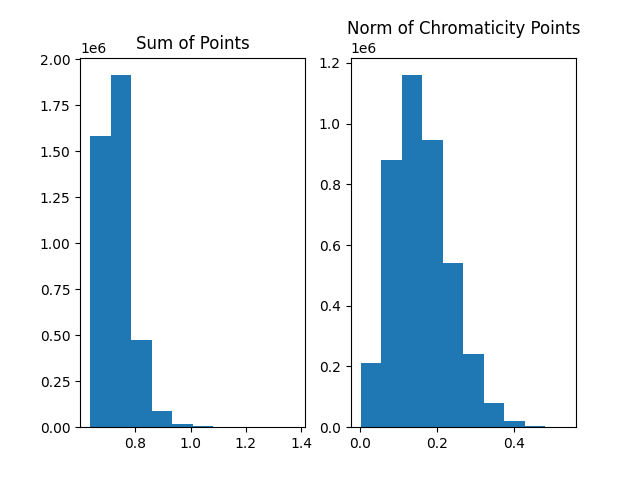

In [12]:
HMatrix = getHeringMatrix(4)
Tmat = maxbasis.get_cone_to_maxbasis_transform()
maxbasis_pts = (Tmat @ point_cloud.T).T
chrom_pts = transformToChromaticity(maxbasis_pts)
hering_max = (HMatrix@maxbasis_pts.T).T

fig, axs = plt.subplots(1, 2)

axs[0].hist(hering_max[:, 0])
axs[0].set_title('Sum of Points')
axs[1].hist(np.linalg.norm(chrom_pts, axis=1))
axs[1].set_title('Norm of Chromaticity Points')
plt.show()

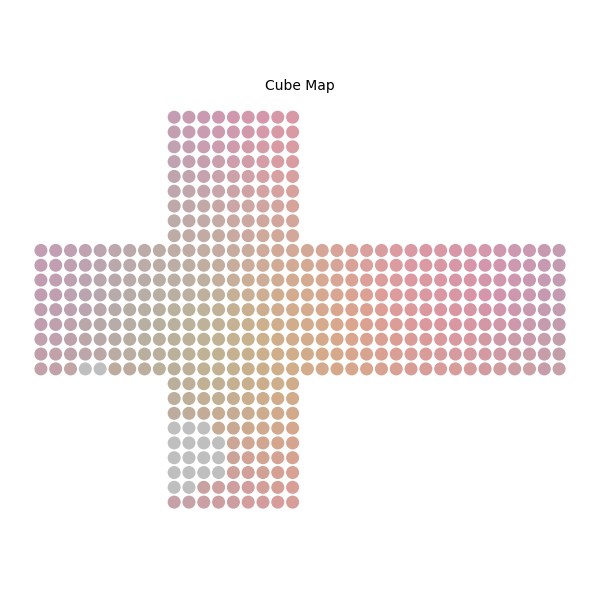

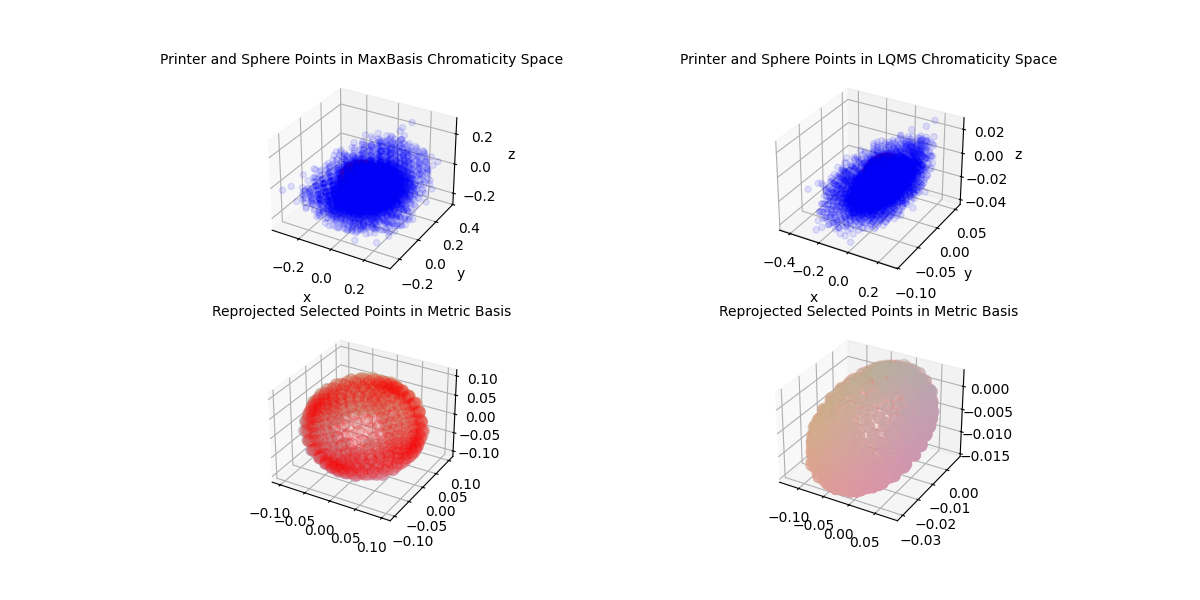

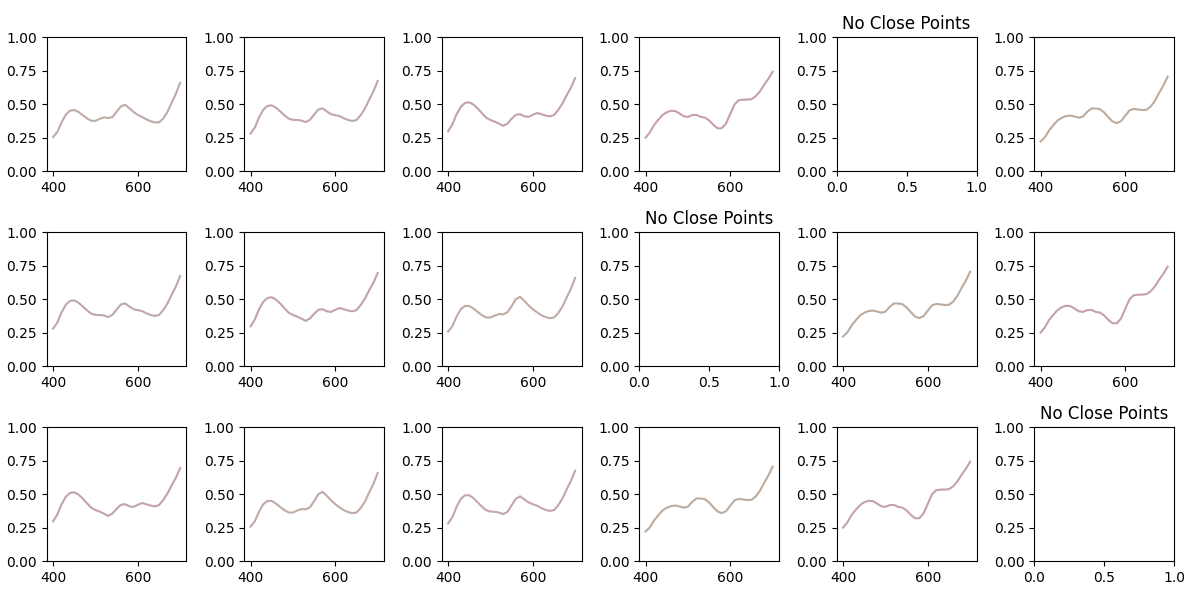

(array([[ 0.69816683, -0.09802439,  0.00248612, -0.00584587],
        [ 0.70072123, -0.10209026, -0.00356534, -0.01571959],
        [ 0.69898579, -0.09219011, -0.00821132, -0.02936878],
        ..., 
        [ 0.69912618,  0.0562944 ,  0.03666544,  0.07222773],
        [ 0.69902103,  0.0493461 ,  0.03842299,  0.07893119],
        [ 0.69900642,  0.03608928,  0.04185532,  0.07982456]]),
 array([ 256671,  471146,  870316, 1055094, 1444519, 1424167, 2222043,
        2211857, 2405896,   91888,  276666,  247432,  646665, 1035648,
        1629320, 2017840, 2611028, 3204216,   71957,   82186,   52952,
         452185,  842558, 1025947, 1414467, 2007676, 3000013,  110895,
          81745,   82672,  268377,  647173, 1231564, 1619621, 2007699,
        2201717,  110454,   81283,   82231,   73434,  453157,  831490,
        1619644, 2212369, 2006774,  100268,  100753,   91493,   72509,
         461977,  840752,  820314, 2017448, 2610173,  109551,  110015,
         100755,   81792,  470776, 1054262, 

In [13]:
cubemap = CubeMap(point_cloud, maxbasis, refs=spectral_pc, ref_wavelengths= np.arange(400, 701, 10), verbose=True)
# lumval = 0.5; satval = 0.2; side_len = 9 # works for lmsq metric
lumval = 0.7; satval = 0.1; side_len = 9
cubemap.display_detailed_cubemap(lumval, satval, side_len, method='hering') # method is if we choose distance to be in the cone basis or the max basis. The basis selects points but it won't be a sphere.

# With Neugebauer Measurements

In [14]:
cellneug = {}
with open(f'../data/nix/28cellNB.csv') as csvf:
    spamreader = csv.reader(csvf, delimiter=';')
    for i, row in enumerate(spamreader):
        if i < 4: continue            
        name = row[4]
        color_data = np.array(row[33:],dtype=float)
        spectra = Spectra(data=color_data, wavelengths=wavelengths10)
        cellneug[name] = spectra

neugebauer = CellNeugebauer(cellneug)
gamut = InkGamut(neugebauer, paper, d65)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Generating point cloud: 41it [00:07,  5.23it/s]                        
Generating point cloud: 41it [00:09,  4.37it/s]                        


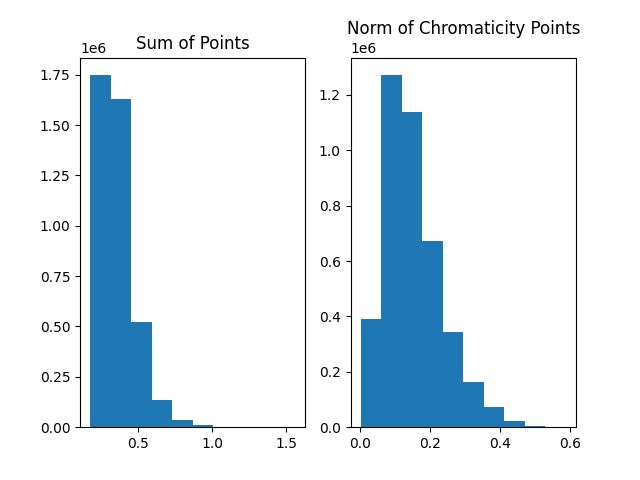

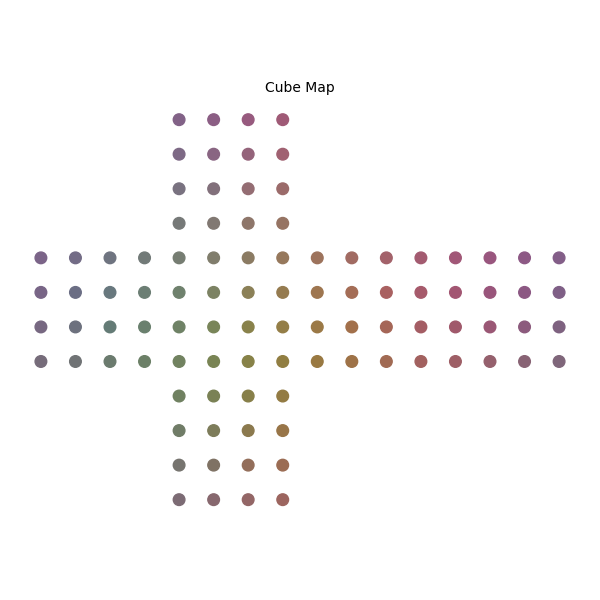

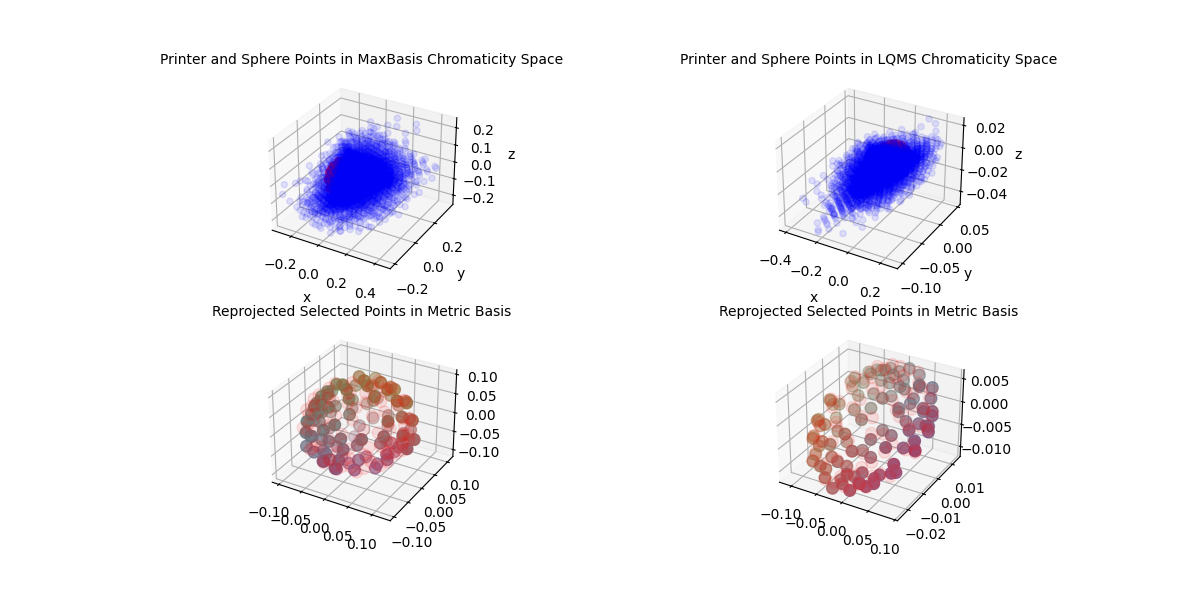

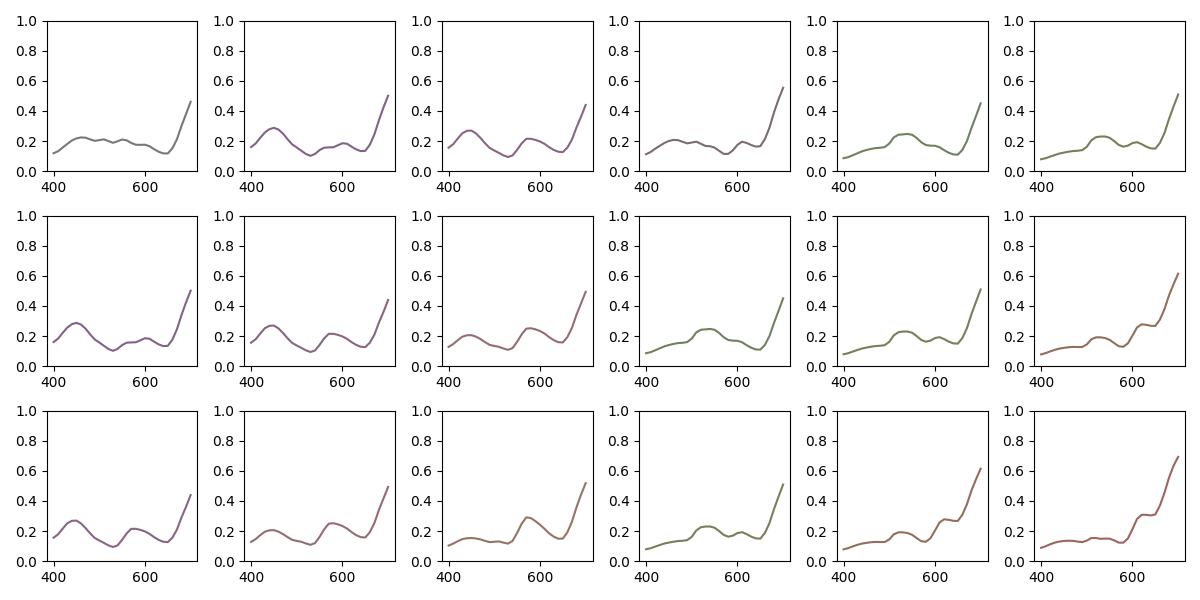

In [15]:
%load_ext autoreload
%autoreload 2
primaries = {}
data = []
with open(f'../data/nix/25lamy.csv') as csvf: # change the file depending on which ink set to use
    spamreader = csv.reader(csvf, delimiter=';')
    for i, row in enumerate(spamreader):
        if i < 4: continue            
        name = row[4]
        color_data = np.array(row[33:],dtype=float)
        spectra = Spectra(data=color_data, wavelengths=wavelengths10)
        primaries[name] = spectra
        data += [tetrachromat.observe(spectra)]


neug = Neugebauer(primaries)
gamut = InkGamut(neug, paper, d65)

spectral_pc, perc = gamut.get_spectral_point_cloud(tetrachromat, stepsize=0.05)
point_cloud, perc = gamut.get_point_cloud(tetrachromat, stepsize=0.05)

HMatrix = getHeringMatrix(4)
Tmat = maxbasis.get_cone_to_maxbasis_transform()
maxbasis_pts = (Tmat @ point_cloud.T).T
chrom_pts = transformToChromaticity(maxbasis_pts)
hering_max = (HMatrix@maxbasis_pts.T).T

fig, axs = plt.subplots(1, 2)

axs[0].hist(hering_max[:, 0])
axs[0].set_title('Sum of Points')
axs[1].hist(np.linalg.norm(chrom_pts, axis=1))
axs[1].set_title('Norm of Chromaticity Points')
plt.show()

cubemap = CubeMap(point_cloud, maxbasis, refs=spectral_pc, ref_wavelengths= np.arange(400, 701, 10), verbose=True)
lumval = 0.3; satval = 0.1; side_len = 4
selected_max, idxs = cubemap.display_detailed_cubemap(lumval, satval, side_len, method='lmsq')

percentages_final = cubemap.get_cubemap_percentages(perc, lumval, satval, side_len, method='lmsq')
np.save(f'../data/nix/4x4_full_percentages.npy', percentages_final) # change the file name saved
indecies = cubemap.get_cubemap_indicies(side_len)
np.save(f'../data/nix/4x4_idx_into_cubemap.npy', indecies)

In [16]:
buckets = gamut.get_buckets_in_hering(maxbasis, 2, 0.05)

Generating point cloud: 41it [00:12,  3.33it/s]                        


Point cloud generated.


In [17]:
# colors = []
# xys = []
# for i in range(5000):
#     for j in range(2):
#         spectra = gamut.get_spectra(buckets[i][1][j])
#         xys += [spectra.to_xyz(d65)[:2]]
#         colors += [spectra.to_rgb(d65)]
# xys = np.array(xys)
# fig = plt.figure()
# plt.scatter(xys[:, 0], xys[:, 1], c=colors)
# plt.show()

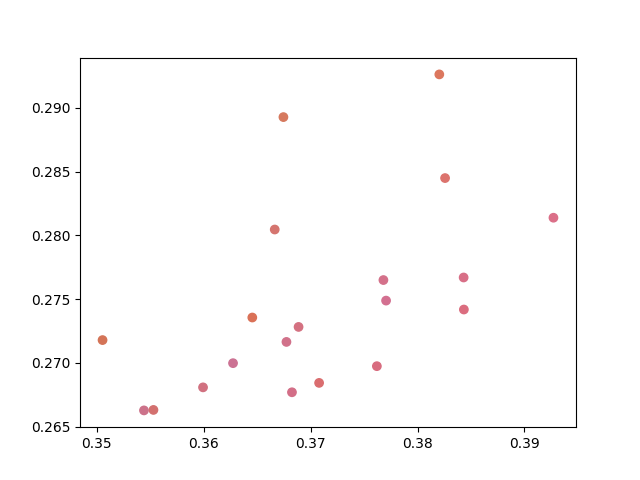

[((0.0, 0.85000000000000009, 0.0, 0.40000000000000002, 0.0), (1.0, 0.0, 0.0, 0.10000000000000001, 0.85000000000000009)), ((0.0, 0.85000000000000009, 0.0, 0.35000000000000003, 0.0), (0.95000000000000007, 0.0, 0.0, 0.050000000000000003, 0.85000000000000009)), ((0.0, 0.85000000000000009, 0.0, 0.35000000000000003, 0.050000000000000003), (0.95000000000000007, 0.0, 0.0, 0.050000000000000003, 0.90000000000000002)), ((0.0, 0.85000000000000009, 0.050000000000000003, 0.35000000000000003, 0.0), (0.95000000000000007, 0.0, 0.0, 0.050000000000000003, 1.0)), ((0.0, 0.85000000000000009, 0.050000000000000003, 0.30000000000000004, 0.0), (0.90000000000000002, 0.0, 0.0, 0.0, 1.0)), ((0.0, 0.85000000000000009, 0.0, 0.5, 0.0), (1.0, 0.0, 0.10000000000000001, 0.25, 0.65000000000000002)), ((0.0, 0.85000000000000009, 0.0, 0.40000000000000002, 0.050000000000000003), (1.0, 0.0, 0.0, 0.10000000000000001, 0.90000000000000002)), ((0.0, 0.80000000000000004, 0.0, 0.65000000000000002, 0.0), (0.95000000000000007, 0.0, 

In [18]:
colors = []
xys = []
percentages = []
for i in range(0, 10):
    # fig = plt.figure()
    # print(buckets[i][0])
    for j in range(2):
        spectra = gamut.get_spectra(buckets[i][1][j])
        xys += [spectra.to_xyz(d65)[:2]]
        colors += [spectra.to_rgb(d65)]
        # print(tetrachromat.observe(spectra))
        # spectra.plot()
    percentages += [buckets[i][1]]
    # plt.title(f'Index {i}')
    # plt.show()
xys = np.array(xys)
fig = plt.figure()
plt.scatter(xys[:, 0], xys[:, 1], c=colors)
plt.show()

print(percentages)

In [19]:
def BackupPrinterMap(c):
    return [(0,c[1],0,0),
            (c[2],0,c[3],0),
            (0,c[0],0,0),
            (0,0,c[4],0)]
backupPrinterNames = ["V","TC","R","M"]

p = Printer(printerMap=BackupPrinterMap, printerNames=backupPrinterNames, directory='../../chromalab')

testDict = {
    "A": (percentages[0][0],percentages[0][1],'87'), #downstairs
    "B": (percentages[1][0],percentages[1][1],'85')
}

for t in testDict.keys():
    inside,outside,secret = testDict[t]
    print(inside)
    # inside = p.CIJKtoCMYIJK(p.div100(inside)) #if the printer values are out of 1, or are 6d, you can skip those steps
    # outside = p.CIJKtoCMYIJK(p.div100(outside))
    p.generate_CC(inside,outside,0,secret,t,True)


(0.0, 0.85000000000000009, 0.0, 0.40000000000000002, 0.0)
18
24
20
25
18
24
24
24
14
24
13
25
12
24
12
25
20
26
20
13
19
20
12
24
14
20
13
25
13
26
20
24
19
18
12
18
25
20
13
13
25
24
24
12
20
26
20
14
13
12
18
19
19
12
12
20
26
25
18
24
14
20
24
25
20
12
25
24
18
24
25
13
18
24
25
18
24
25
26
19
26
20
19
14
24
25
26
14
13
25
18
20
19
14
20
20
19
18
26
13
20
18
26
12
13
13
19
20
24
14
24
19
14
25
19
12
24
12
20
25
14
18
18
24
13
13
12
13
25
14
14
18
18
19
14
20
24
14
19
26
14
24
14
12
24
20
18
25
24
24
26
20
24
18
24
19
26
19
14
14
13
25
26
14
13
13
14
25
24
20
25
24
14
20
13
12
19
13
24
25
20
12
13
19
25
26
26
12
12
26
24
26
26
13
24
19
14
12
25
26
14
19
13
13
18
24
19
19
26
24
19
12
12
18
14
19
25
19
20
26
26
19
12
26
24
26
20
20
25
20
13
14
14
12
14
20
18
14
13
20
13
20
25
14
12
20
19
26
14
14
19
13
20
26
20
24
12
14
14
26
26
18
13
13
19
26
18
25
12
20
26
13
14
13
12
26
13
13
26
18
18
24
26
14
18
20
24
19
13
18
14
12
14
25
13
20
18
20
24
24
13
12
25
25
20
13
13
13
18
14
18
19
24
19


In [20]:
test_spectra = {}
with open(f'../data/nix/29ishi.csv') as csvf:
    spamreader = csv.reader(csvf, delimiter=';')
    for i, row in enumerate(spamreader):
        if i < 4: continue            
        name = row[4]
        color_data = np.array(row[33:],dtype=float)
        spectra = Spectra(data=color_data, wavelengths=wavelengths10)
        test_spectra[name] = spectra

for test_spectra

{'05,70,0,75,0': <chromalab.spectra.Spectra at 0x28a3e2150>,
 '90,0,0,5,95': <chromalab.spectra.Spectra at 0x3766ee1d0>,
 '0,65,0,70,5': <chromalab.spectra.Spectra at 0x308b86c10>,
 '80,0,05,90': <chromalab.spectra.Spectra at 0x30ef70d10>}